In [1]:
import numpy as np
from gradvi.normal_means import NormalMeans, NormalMeansFromPosterior
from gradvi.models import basis_matrix
from gradvi.tests import toy_priors, toy_data

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)

# Local imports
import tf_data
import tf_methods
import utils

In [2]:
def wavelet_func_norm(z, y, s2, jac = True):
    """
    Calculate the frobenius norm of the objective function 
    and its gradients with respect to the parameters
    """
    r = y - z
    rTr = np.dot(r, r)
    h = 0.5 * rTr / s2
    if jac:
        dhdx  = - r / s2
        return h, dhdx
    return h

def wavelet_func_penalty(z, y, s2, W, dj, prior, jac = True, 
                         invert_method = 'trisection', invert_options = {}):
    """
    Calculate the penalty term of the objective function 
    and its gradients with respect to the parameters
    """
    b = np.dot(W, z)
    sj2 = s2 / dj

    nm = NormalMeansFromPosterior(
            b, prior, sj2,
            scale = s2, d = dj,
            method = invert_method, **invert_options)

    Pb, dPdb, dPdw, dPdsj2 = nm.penalty_operator(jac = True)
    dPds2 = dPdsj2 / dj

    h = np.sum(Pb)
    if jac:
        dhdx  = np.dot(W.T, dPdb)
        dhdw  = np.sum(dPdw, axis = 0)
        dhda  = prior.wmod_grad(dhdw)
        dhds2 = np.sum(dPds2)
        return h, dhdx, dhda, dhds2
    return h

In [3]:
n = 512
x = np.linspace(0, 1, n)
np.random.seed(100)

degrees = [0, 1, 2, 3]
nknots  = 4
strue = 0.1
knots = np.linspace(0, 1, nknots+2)[1:-1]

data = dict()

for degree in degrees:
    bfix = np.random.normal(0, 1, size = nknots + degree)
    data[degree] = tf_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                        signal = "fixed", bfix = bfix, seed = 100, 
                        include_intercept = False)

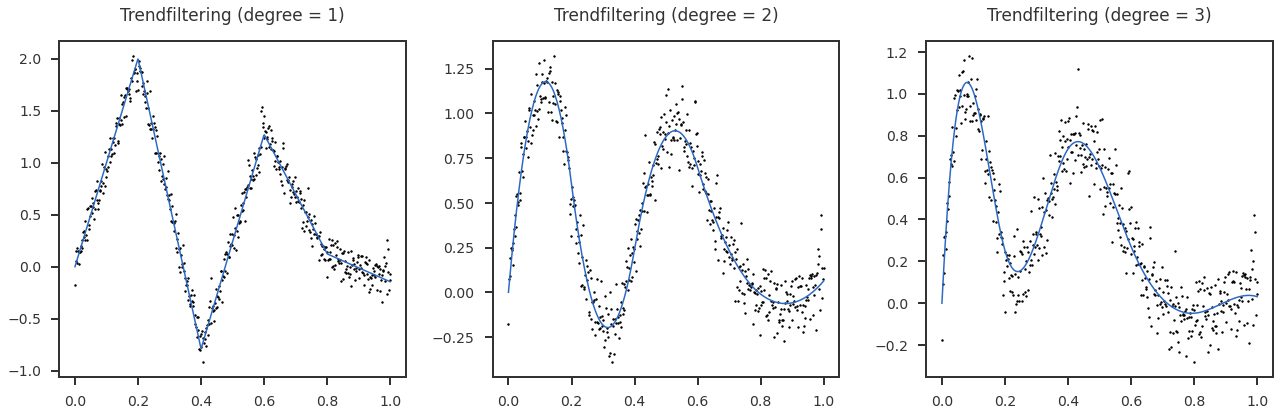

In [4]:
fig = plt.figure(figsize = (18, 6))
for i, d in enumerate(degrees[1:]):
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(data[d].x, data[d].y, s = 2, color = 'black')
    ax.plot(data[d].x, data[d].ytrue)
    ax.set_title(f"Trendfiltering (degree = {d})", pad = 20)
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
plt.show()

In [5]:
from scipy import optimize as sp_optimize

def minimize_norm(zinit, y, s2):
    args = (y, s2)
    opt = sp_optimize.minimize(wavelet_func_norm, zinit, args, 
            method = 'cg', jac = True, options = {'disp': True})
    return opt


def minimize_penalty(zinit, y, s2init, prior, degree):
    
    global uprior
    
    uprior = prior.copy()
    
    def funjac(params, y, W, dj):
        global uprior
        n = y.shape[0]
        k = uprior.k
        z  = params[:n]
        ak = params[n:n+k]
        s2 = params[n+k]
        uprior.update_wmod(ak)
        h, dhdz, dhda, dhds2 = wavelet_func_penalty(z, y, s2, W, dj, uprior)
        dhdx = np.concatenate((dhdz, dhda, np.array([dhds2])))
        return h, dhdx
        
    H      = basis_matrix.trendfiltering_scaled(y.shape[0], degree)
    Hinv   = basis_matrix.trendfiltering_inverse_scaled(y.shape[0], degree)
    dj     = np.sum(np.square(H), axis = 0)
    
    xinit  = np.concatenate((zinit, uprior.wmod, np.array([s2init])))    
    args   = (y, Hinv, dj)
    bounds = [(None, None) for x in zinit] \
             + [(None, None) for x in range(uprior.k)] \
             + [(1e-8, None)]
    opt    = sp_optimize.minimize(funjac, xinit, args, 
                method = 'l-bfgs-b', bounds = bounds, jac = True, 
                options = {'disp':True, 'maxiter': 1000})
    return opt, uprior

In [6]:
priors = toy_priors.get_all()
prior  = priors[0]

In [7]:
dk = 3
s2 = np.square(strue)
opt, uprior = minimize_penalty(data[dk].ytrue, data[dk].y, s2, prior, dk)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          519     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72886D+04    |proj g|=  4.80329D+09

At iterate    1    f=  2.45960D+04    |proj g|=  5.62184D+09

At iterate    2    f=  2.45669D+04    |proj g|=  6.57336D+09

At iterate    3    f=  2.45327D+04    |proj g|=  7.37491D+09

At iterate    4    f=  2.44996D+04    |proj g|=  7.63908D+09

At iterate    5    f=  2.44926D+04    |proj g|=  7.86710D+09

At iterate    6    f=  2.44779D+04    |proj g|=  9.03838D+09

At iterate    7    f=  2.44637D+04    |proj g|=  6.26667D+09

At iterate    8    f=  2.44547D+04    |proj g|=  6.70676D+09

At iterate    9    f=  2.44450D+04    |proj g|=  8.26802D+09

At iterate   10    f=  2.44382D+04    |proj g|=  6.40465D+09

At iterate   11    f=  2.44269D+04    |proj g|=  7.00640D+09

At iterate   12    f=  2.44264D+04    |proj g|=  9.42635D+09

At iterate   13    f=  2.4


At iterate  130    f=  2.12329D+04    |proj g|=  1.43123D+10

At iterate  131    f=  2.12302D+04    |proj g|=  1.47703D+10

At iterate  132    f=  2.12259D+04    |proj g|=  1.24177D+10

At iterate  133    f=  2.12215D+04    |proj g|=  1.35562D+10

At iterate  134    f=  2.12188D+04    |proj g|=  1.28979D+10

At iterate  135    f=  2.12130D+04    |proj g|=  1.52050D+10

At iterate  136    f=  2.12122D+04    |proj g|=  1.50441D+10

At iterate  137    f=  2.12113D+04    |proj g|=  1.56815D+10

At iterate  138    f=  2.12097D+04    |proj g|=  1.47168D+10

At iterate  139    f=  2.12089D+04    |proj g|=  1.45389D+10

At iterate  140    f=  2.12081D+04    |proj g|=  1.57765D+10

At iterate  141    f=  2.12054D+04    |proj g|=  1.57570D+10

At iterate  142    f=  2.12023D+04    |proj g|=  1.48497D+10

At iterate  143    f=  2.11994D+04    |proj g|=  1.47965D+10

At iterate  144    f=  2.11969D+04    |proj g|=  1.42225D+10

At iterate  145    f=  2.11968D+04    |proj g|=  1.42324D+10

At iter


At iterate  263    f=  2.02946D+04    |proj g|=  5.45403D+09

At iterate  264    f=  2.02940D+04    |proj g|=  1.50141D+10

At iterate  265    f=  2.02554D+04    |proj g|=  5.28620D+09

At iterate  266    f=  2.02325D+04    |proj g|=  1.16093D+10

At iterate  267    f=  2.02291D+04    |proj g|=  1.09237D+10

At iterate  268    f=  2.02206D+04    |proj g|=  1.16086D+10

At iterate  269    f=  2.01778D+04    |proj g|=  1.12398D+10

At iterate  270    f=  2.01744D+04    |proj g|=  1.14239D+10

At iterate  271    f=  2.01374D+04    |proj g|=  4.88488D+09

At iterate  272    f=  1.99175D+04    |proj g|=  7.37113D+09

At iterate  273    f=  1.99143D+04    |proj g|=  1.19465D+10

At iterate  274    f=  1.98854D+04    |proj g|=  5.60662D+09

At iterate  275    f=  1.98496D+04    |proj g|=  3.92862D+09

At iterate  276    f=  1.98494D+04    |proj g|=  3.36876D+09

At iterate  277    f=  1.98424D+04    |proj g|=  3.00210D+09

At iterate  278    f=  1.98323D+04    |proj g|=  6.78003D+09

At iter


At iterate  394    f=  1.93092D+04    |proj g|=  1.01974D+10

At iterate  395    f=  1.93091D+04    |proj g|=  6.54832D+09

At iterate  396    f=  1.93091D+04    |proj g|=  4.56018D+09

At iterate  397    f=  1.93091D+04    |proj g|=  3.31884D+09

At iterate  398    f=  1.93091D+04    |proj g|=  5.23283D+09

At iterate  399    f=  1.93090D+04    |proj g|=  2.80686D+09

At iterate  400    f=  1.93090D+04    |proj g|=  4.74535D+09

At iterate  401    f=  1.93089D+04    |proj g|=  5.64286D+09

At iterate  402    f=  1.93088D+04    |proj g|=  6.93746D+09

At iterate  403    f=  1.93022D+04    |proj g|=  1.17506D+10

At iterate  404    f=  1.93022D+04    |proj g|=  1.14259D+10

At iterate  405    f=  1.93015D+04    |proj g|=  1.22163D+10

At iterate  406    f=  1.93013D+04    |proj g|=  1.22543D+10

At iterate  407    f=  1.93009D+04    |proj g|=  1.18096D+10

At iterate  408    f=  1.93008D+04    |proj g|=  8.50890D+09

At iterate  409    f=  1.93006D+04    |proj g|=  4.93696D+09

At iter


At iterate  526    f=  1.90937D+04    |proj g|=  2.38864D+10

At iterate  527    f=  1.90921D+04    |proj g|=  2.35381D+10

At iterate  528    f=  1.90904D+04    |proj g|=  1.06906D+10

At iterate  529    f=  1.90854D+04    |proj g|=  1.76017D+10

At iterate  530    f=  1.90845D+04    |proj g|=  1.51679D+10

At iterate  531    f=  1.90796D+04    |proj g|=  1.50966D+10

At iterate  532    f=  1.90784D+04    |proj g|=  1.43136D+10

At iterate  533    f=  1.90774D+04    |proj g|=  1.49660D+10

At iterate  534    f=  1.90770D+04    |proj g|=  1.65112D+10

At iterate  535    f=  1.90752D+04    |proj g|=  1.28247D+10

At iterate  536    f=  1.90745D+04    |proj g|=  1.35827D+10

At iterate  537    f=  1.90734D+04    |proj g|=  1.15857D+10

At iterate  538    f=  1.90728D+04    |proj g|=  1.64055D+10

At iterate  539    f=  1.90721D+04    |proj g|=  1.29451D+10

At iterate  540    f=  1.90720D+04    |proj g|=  2.12578D+10

At iterate  541    f=  1.90708D+04    |proj g|=  1.73708D+10

At iter


At iterate  660    f=  1.89218D+04    |proj g|=  1.54151D+10

At iterate  661    f=  1.89181D+04    |proj g|=  2.56269D+10

At iterate  662    f=  1.89151D+04    |proj g|=  2.18878D+10

At iterate  663    f=  1.89135D+04    |proj g|=  2.08205D+10

At iterate  664    f=  1.89124D+04    |proj g|=  1.22248D+10

At iterate  665    f=  1.89117D+04    |proj g|=  1.90222D+10

At iterate  666    f=  1.89113D+04    |proj g|=  2.04996D+10

At iterate  667    f=  1.89104D+04    |proj g|=  2.28867D+10

At iterate  668    f=  1.89092D+04    |proj g|=  2.14551D+10

At iterate  669    f=  1.89083D+04    |proj g|=  1.21053D+10

At iterate  670    f=  1.89079D+04    |proj g|=  1.06629D+10

At iterate  671    f=  1.89078D+04    |proj g|=  1.20294D+10

At iterate  672    f=  1.89076D+04    |proj g|=  1.60240D+10

At iterate  673    f=  1.89075D+04    |proj g|=  1.26301D+10

At iterate  674    f=  1.89073D+04    |proj g|=  1.44369D+10

At iterate  675    f=  1.89073D+04    |proj g|=  1.22397D+10

At iter


At iterate  796    f=  1.88421D+04    |proj g|=  8.18015D+09

At iterate  797    f=  1.88420D+04    |proj g|=  6.10523D+09

At iterate  798    f=  1.88418D+04    |proj g|=  7.11190D+09

At iterate  799    f=  1.88387D+04    |proj g|=  1.82429D+10

At iterate  800    f=  1.88387D+04    |proj g|=  1.82538D+10

At iterate  801    f=  1.88385D+04    |proj g|=  1.75041D+10

At iterate  802    f=  1.88382D+04    |proj g|=  1.21559D+10

At iterate  803    f=  1.88381D+04    |proj g|=  1.37164D+10

At iterate  804    f=  1.88380D+04    |proj g|=  1.24973D+10

At iterate  805    f=  1.88377D+04    |proj g|=  9.49157D+09

At iterate  806    f=  1.88375D+04    |proj g|=  9.86265D+09

At iterate  807    f=  1.88374D+04    |proj g|=  1.48140D+10

At iterate  808    f=  1.88371D+04    |proj g|=  1.29509D+10

At iterate  809    f=  1.88367D+04    |proj g|=  1.29147D+10

At iterate  810    f=  1.88365D+04    |proj g|=  1.28249D+10

At iterate  811    f=  1.88361D+04    |proj g|=  1.37133D+10

At iter


At iterate  932    f=  1.87005D+04    |proj g|=  8.75340D+09

At iterate  933    f=  1.87004D+04    |proj g|=  8.73822D+09

At iterate  934    f=  1.86998D+04    |proj g|=  6.01508D+09

At iterate  935    f=  1.86996D+04    |proj g|=  1.62759D+10

At iterate  936    f=  1.86993D+04    |proj g|=  6.53534D+09

At iterate  937    f=  1.86991D+04    |proj g|=  1.88025D+10

At iterate  938    f=  1.86989D+04    |proj g|=  9.08299D+09

At iterate  939    f=  1.86987D+04    |proj g|=  9.43305D+09

At iterate  940    f=  1.86986D+04    |proj g|=  5.54235D+09

At iterate  941    f=  1.86985D+04    |proj g|=  6.21053D+09

At iterate  942    f=  1.86981D+04    |proj g|=  1.55435D+10

At iterate  943    f=  1.86978D+04    |proj g|=  1.07332D+10

At iterate  944    f=  1.86974D+04    |proj g|=  1.11852D+10

At iterate  945    f=  1.86974D+04    |proj g|=  1.01025D+10

At iterate  946    f=  1.86971D+04    |proj g|=  1.83844D+10

At iterate  947    f=  1.86969D+04    |proj g|=  6.47220D+09

At iter

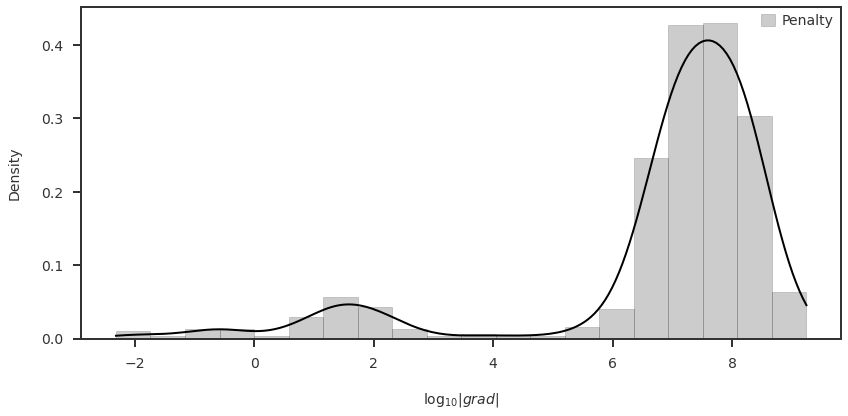

In [9]:
from scipy.stats import gaussian_kde as sp_gaussian_kde

def remove_outliers(data):
    quant3, quant1 = np.percentile(data, [75 ,25])
    iqr = quant3 - quant1
    xmin = quant1 - 1.5 * iqr
    xmax = quant3 + 1.5 * iqr
    Xkeep = np.array([x for x in data if (x >= xmin and x <= xmax)])
    return Xkeep

def density_plot(ax, data, label = '', color = 'k'):
    x = data.copy()
    #x = remove_outliers(data)
    xmin = np.min(x)
    xmax = np.max(x)
    kernel = sp_gaussian_kde(x)
    # smoothing
    kernel.covariance_factor = lambda : .2
    kernel._compute_covariance()
    
    xvals  = np.linspace(xmin, xmax, 200)
    density = kernel(xvals)
    ax.hist(x, density = True, label = label, color = color, alpha = 0.2)
    ax.plot(xvals, density, lw = 2, color = color)
    return

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)


xvals = np.log10(np.abs(opt.jac))
density_plot(ax1, xvals, label = 'Penalty')

ax1.legend()
ax1.set_ylabel("Density")
ax1.set_xlabel(r"$\log_{10}|grad|$")

#ax2.legend()
#mpl_utils.plot_diag(ax2)

fig.tight_layout()
# fig.subplots_adjust(wspace=0.35)
# utils.saveplot(fig, 'trendfiltering_simple_examples_wavelet_moving_average_init_properties')
plt.show()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 1
         Function evaluations: 4
         Gradient evaluations: 4
true   h = 285.7314247669176
zero   h = 6260.82072415636
rand   h = 566.8502761348672
optm   h = 7.528426807611247e-26


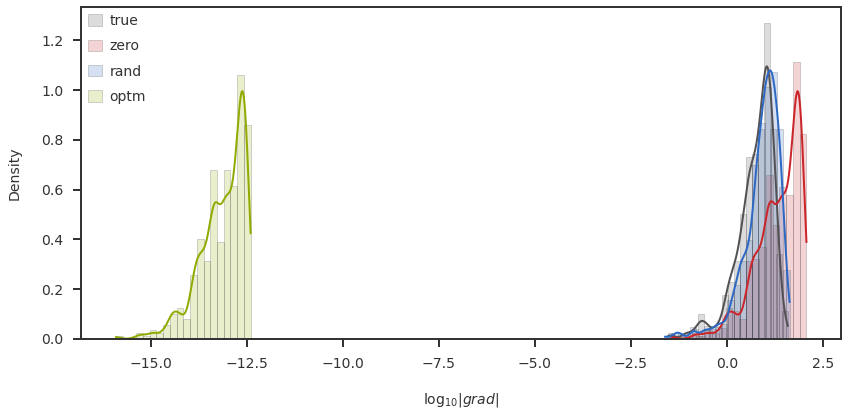

In [7]:
dk = 3

s2  = np.square(strue)

zdict = {
    'true': data[dk].ytrue,
    'zero': np.zeros(n),
    'rand': data[dk].ytest,
    'optm': minimize_norm(np.zeros(n), data[dk].y, s2).x
}

zcolors = {
    'true': "#535154",
    'zero': "#CC2529",
    'rand': "#2D69C4",
    'optm': "#93AA00"
}

obj = dict()
dha = dict()

for k, z in zdict.items():
    obj[k], dha[k] = wavelet_func_norm(z, data[dk].y, s2, jac = True)
    print(f"{k:6s} h = {obj[k]}")

    
from scipy.stats import gaussian_kde as sp_gaussian_kde

def remove_outliers(data):
    quant3, quant1 = np.percentile(data, [75 ,25])
    iqr = quant3 - quant1
    xmin = quant1 - 1.5 * iqr
    xmax = quant3 + 1.5 * iqr
    Xkeep = np.array([x for x in data if (x >= xmin and x <= xmax)])
    return Xkeep

def density_plot(ax, data, label = '', color = 'k'):
    x = data.copy()
    #x = remove_outliers(data)
    xmin = np.min(x)
    xmax = np.max(x)
    kernel = sp_gaussian_kde(x)
    # smoothing
    kernel.covariance_factor = lambda : .2
    kernel._compute_covariance()
    
    xvals  = np.linspace(xmin, xmax, 200)
    density = kernel(xvals)
    ax.hist(x, density = True, label = label, color = color, alpha = 0.2)
    ax.plot(xvals, density, lw = 2, color = color)
    return

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(111)

zkeys = ['true', 'zero', 'rand', 'optm']
for k in zkeys:
    xvals = np.log10(np.abs(dha[k]))
    #xvals = dha[k]
    density_plot(ax1, xvals, label = k, color = zcolors[k])

ax1.legend()
ax1.set_ylabel("Density")
ax1.set_xlabel(r"$\log_{10}|grad|$")

#ax2.legend()
#mpl_utils.plot_diag(ax2)

fig.tight_layout()
# fig.subplots_adjust(wspace=0.35)
# utils.saveplot(fig, 'trendfiltering_simple_examples_wavelet_moving_average_init_properties')
plt.show()

In [ ]:


degree_colors = {
    0: "#535154",
    1: "#CC2529",
    2: "#2D69C4",
    3: "#93AA00",
}